
<a name="Overview"></a>
## Overview

In this notebook, we will be performing Exploratory Data Analysis on a dataset of Titanic passengers.

We aim to answer the following questions using this data:

* What is the most important factor in determining survival of the Titanic incident?
* In the movie, the upper-class passengers were given preference on lifeboats. Does this show in the data?
* “Womenandchildrenfirst”. Was this the case?
* Note another observation we can make from the data

<a name="Table-of-contents"></a>
## Table of Contents

* [Overview](#Overview)
* [Table of Contents](#Table-of-contents)
* [Libraries Used](#Libraries-Used)
* [Data Structure](#Data-Structure)
* [Missing Data](#Missing-data)

## Libraries-Used

This notebook was written using python 3.12.2

Please also see requirements.txt for exact versions of key libraries.

In [3374]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

[^ Back to table of contents ^](#Table-of-contents)

<a name="Data-Structure"></a>
## Data structure

Let's load the data and take a look at what we have

### Features

In [3375]:
df = pd.read_csv('Titanic.csv')

print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3376]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Some of those features are self explanatory, but a few I had no idea what they referred to and no meta-data was provided.

Luckily, this is a very commonly used dataset, so I was able to find this description of the features online:

| Feature      | Description                                |
|--------------|--------------------------------------------|
| Pclass       | Ticket class                               |
| SibSp        | # of siblings / spouses aboard the Titanic |
| Parch        | # of parents / children aboard the Titanic |
| ticket       | Ticket number                              |


## Data to ignore

<a name="Missing-data"></a>
## Missing data

In [3377]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Missing Data: Cabin
Out of 891 records, we're missing 687 entries for Cabin.


In [3378]:
# Let's take a peek at the first 10 unique values
df["Cabin"].unique()[:10]

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78'], dtype=object)

This data is potentially useful (Did cabin number indicate which deck it was on, and were some decks more dangerous than others?).  We could produce a feature "Deck" from this data which might be interesting.

Unfortunately the very high level of missing data is likely to do with poor record-keeping, and either we won't be able to sensibly predict deck for the observations without this data, or it would effectively map to another feature *pclass* making it redundant.

So I'm going to just drop this feature for now.

In [3379]:
df.drop(columns=["Cabin"], inplace=True)

### Missing Data: Age
We could convert age into some age range categories, but before we do that, is missing age data based on other characteristics?  If we attempt to impute age will we be skewing outcomes for our target?

I expect this to be MCAR due to poor record keeping, and I'm not confident we have a way of predicting age based on other factors.

Before I use a simple method (i.e. setting to median (age destribution is skewed, so I don't think mean is appropriate) I just want to quickly check that assigning this data isn't going to add too much bias, and make people at the mean more likely to 




<Axes: title={'center': 'Median age'}, xlabel='Survived', ylabel='Count'>

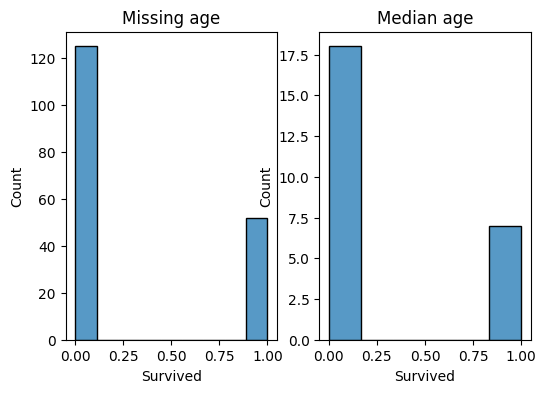

In [3380]:
df_missing_age = df[df["Age"].isna()]
# And what about for the mode age?
median_age = round(df['Age'].median())
mean_age = round(df['Age'].mean())

(f, ax) = plt.subplots(1,2, figsize=(6,4))

ax[0].set_title("Missing age")
sns.histplot(data=df_missing_age, x="Survived", ax=ax[0])

ax[1].set_title("Median age")
sns.histplot(data=df[df['Age'] == median_age], x="Survived", ax=ax[1])


The proportion of survived values is about the same, so it should be safe to assign the mode to missing values without introducing too much bias


In [3381]:
# What if we just chuck it instead?
df.dropna(subset=['Age'], inplace=True)

# Set to median
# df.loc[df['Age'].isnull(), 'Age'] = median_age

### Missing data: Embarked

Only 2 observations with this feature missing, I believe this is MCAR so let's just set it to the most frequest value (S)

In [3382]:
df['Embarked'].value_counts()

df.loc[df['Embarked'].isnull(), 'Embarked'] = 'S'

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

No more missing values!

## Pre-processing



In [3383]:
# I wonder if we can provide this to read_csv as a faster hint when loading data...
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

### Any Outliers to remove?

There only non-discrete numeric values in this dataset is fare, let's run a box plot of this to see if there are a lot of outliers.

If there are, let's windsorize this data

<Axes: ylabel='Fare'>

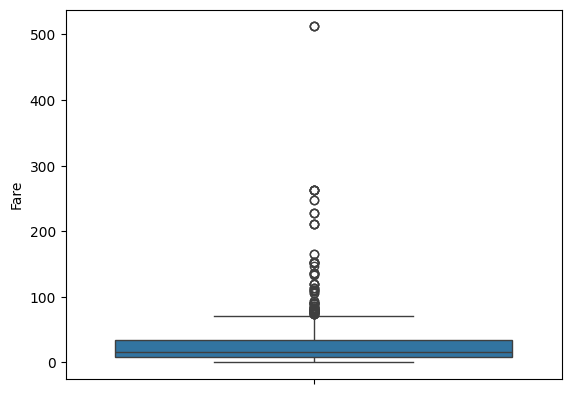

In [3384]:
sns.boxplot(df['Fare'])

<Axes: xlabel='Fare', ylabel='Count'>

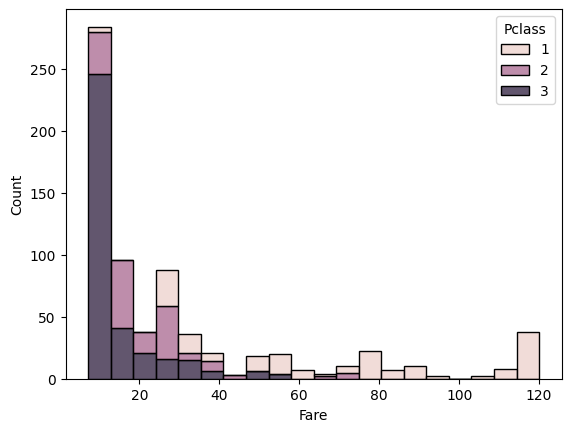

In [3385]:

len(df['Fare'].unique())

from scipy.stats import mstats

df['Fare'] = mstats.winsorize(df['Fare'], limits=[0.05, 0.05])


# df.hist(figsize=[10, 10])
sns.histplot(data=df, x='Fare', hue='Pclass', multiple="stack")


### Categorization

In [3386]:
# enc = OneHotEncoder()

# with_dummies = pd.get_dummies(df, columns=['Survived'])
# # enc.fit_transform(df, ['Survived'])

# with_dummies.head()

<Axes: xlabel='Survived', ylabel='Count'>

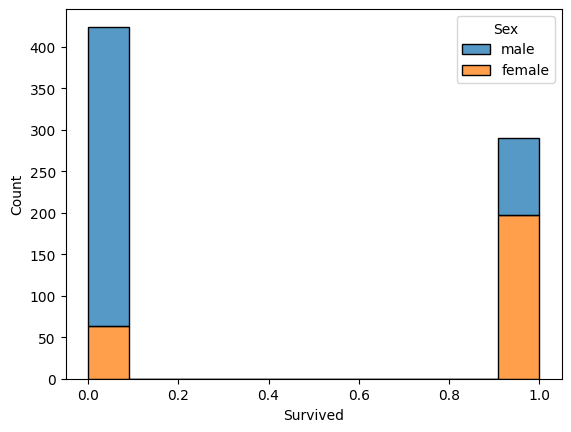

In [3387]:
sns.histplot(df, x='Survived', hue="Sex", multiple="stack")

We can definitely see from this histogram, that a much higher percentage of women survived than men.

Not all women survived though!

What about class?

<Axes: xlabel='Survived', ylabel='Count'>

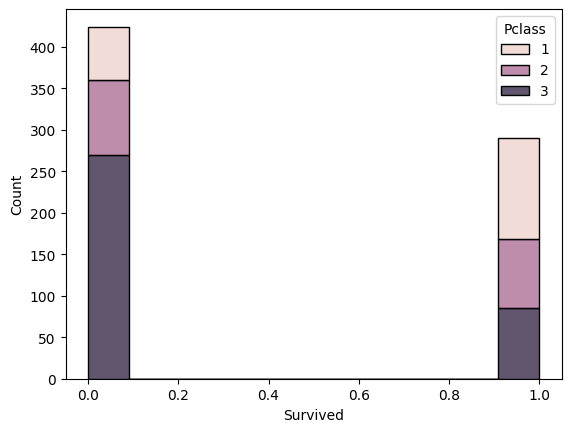

In [3388]:
sns.histplot(df, x='Survived', hue="Pclass", multiple="stack")

Class has a large effect too.

It's not looking good for Males in third class!

What about children?  Let's create a new field to represent a child, and let's define child as anyone 16 or under

<Axes: xlabel='Survived', ylabel='Count'>

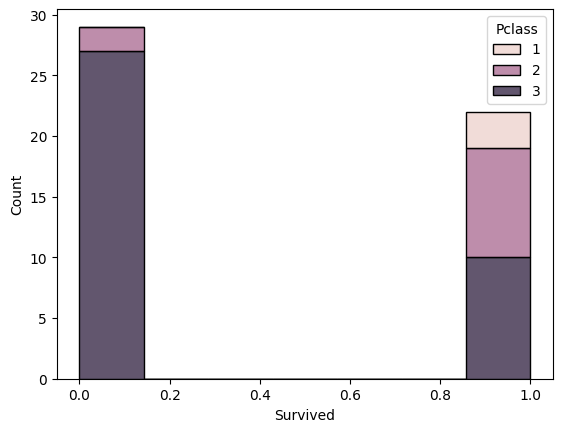

In [3389]:
df['Child'] = False
df.loc[df['Age'] <= 16, 'Child'] = True
sns.histplot(df[(df['Child'] == True) & (df['Sex'] == "male")], x="Survived", hue="Pclass", color="tab10", multiple="stack")



Ouch.  So it's not women & chidren first, it's very much "1st and 2nd class women and children first"

A large number of 3rd class children sadly died.

Is this true of non-child women too?

<Axes: xlabel='Survived', ylabel='Count'>

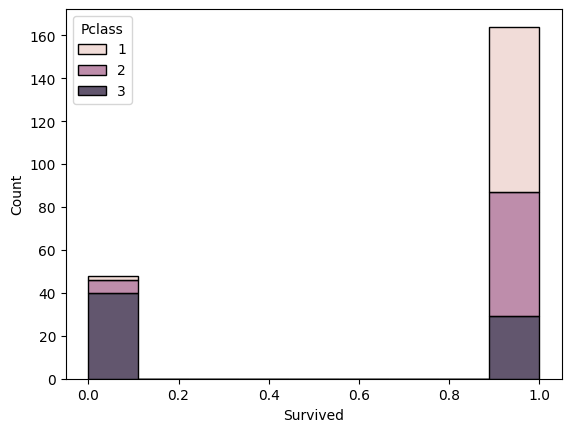

In [3390]:
sns.histplot(df[(df['Sex'] == 'female') & (df['Child'] == False)], x="Survived", hue="Pclass", multiple="stack")

Very much so :(

Of the men (non-child Males) that survived, how did that break down by class?

<Axes: xlabel='Survived', ylabel='Count'>

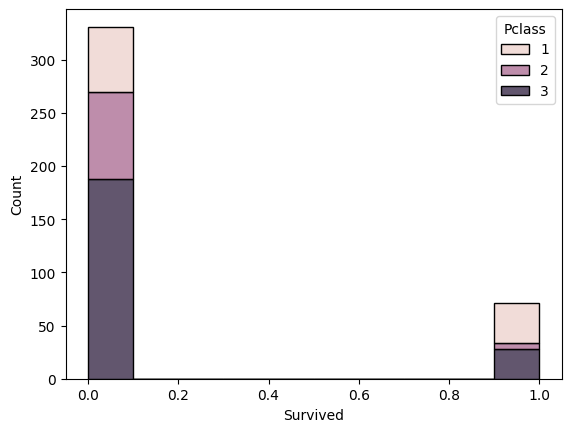

In [3391]:
sns.histplot(df[(df['Sex'] == 'male') & (df['Child'] == False )], x="Survived", multiple="stack", hue="Pclass")

<Axes: xlabel='Age', ylabel='Density'>

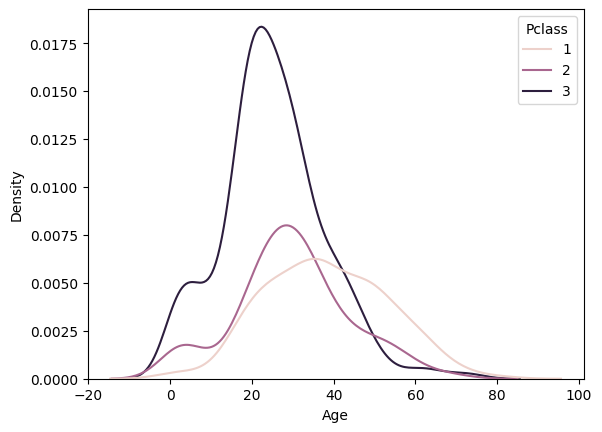

In [3392]:
# Did Age differ in general with the class?

sns.kdeplot(df, x="Age", hue="Pclass")


There's an interesting difference in density of passengers ages between classes.

For example 1st class passengers are a wider spread of ages, with higher mean age.

3rd class passengers are predominently a certain age around the 20s.

We should go back and use this data to improve our filling in of the missing Age data!  We should assign different ages depending on an observations Pclass!